Data shape: (1715, 201), Number of classes: 7


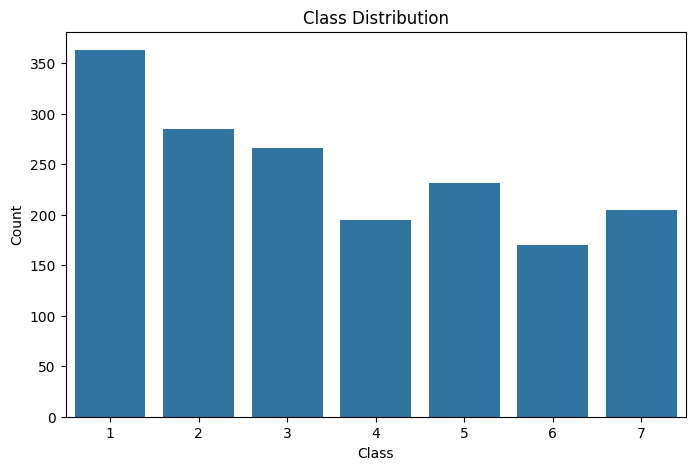

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, cohen_kappa_score, precision_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')

# Load data
url = "https://raw.githubusercontent.com/leaLeGallo/big_data_exam/refs/heads/main/Cancer2025exam.csv"
data = pd.read_csv(url)
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

print(f"Data shape: {X.shape}, Number of classes: {len(np.unique(y))}")

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=data.columns[0], data=data)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


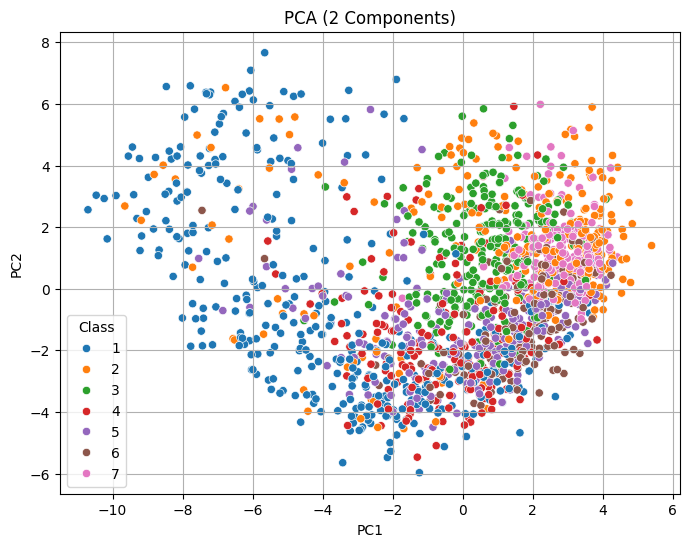

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# PCA Visualization
def plot_pca(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='tab10')
    plt.title("PCA (2 Components)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Class")
    plt.grid(True)
    plt.show()

plot_pca(X, y)


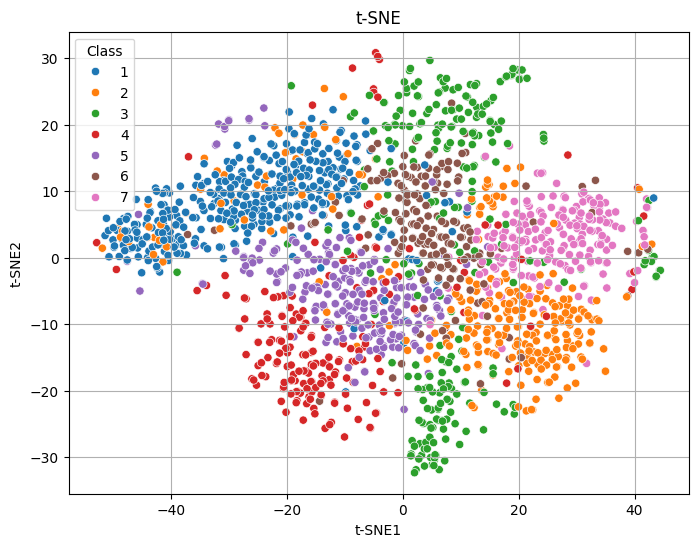

In [5]:

# t-SNE Visualization
def plot_tsne(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='tab10')
    plt.title("t-SNE")
    plt.xlabel("t-SNE1")
    plt.ylabel("t-SNE2")
    plt.legend(title="Class")
    plt.grid(True)
    plt.show()


plot_tsne(X, y)


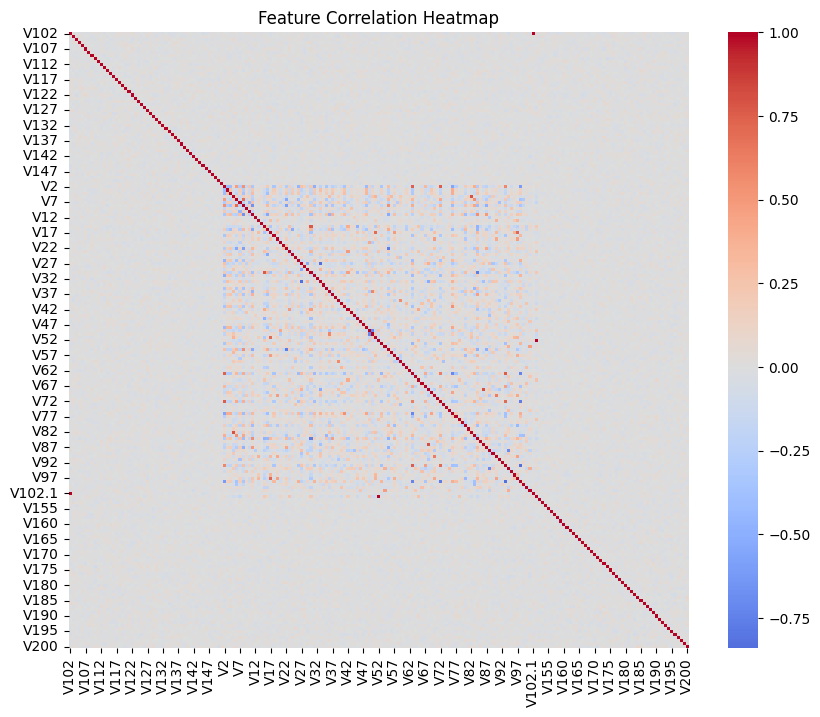

In [5]:
# Correlation heatmap
X_df = pd.DataFrame(X, columns=data.columns[1:])
plt.figure(figsize=(10, 8))
sns.heatmap(X_df.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
def create_outer_splits(X, y, n_splits=5, random_state=42):
    """
    Create stratified splits for outer train-test evaluation.
    Returns list of (train_idx, test_idx) tuples.
    """
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    return list(outer_cv.split(X, y))


def get_classifiers():
    """
    Returns dictionary of classifiers to evaluate.
    """
    return {
        'Logistic Regression': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
        'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
        'KNN': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
        'Naive Bayes': GaussianNB(),
        'AdaBoost': AdaBoostClassifier(random_state=42)
    }


def get_param_grids():
    """
    Slightly expanded but still computationally feasible hyperparameter grids.
    """
    return {
        'Logistic Regression': {
            'clf__C': [0.001, 0.01, 0.1],
            'clf__penalty': ['l2'],
            'clf__solver': ['lbfgs']
        },
        'SVM': {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['rbf'],
            'clf__gamma': ['scale', 'auto']
        },
        'KNN': {
            'clf__n_neighbors': [3, 5, 7, 9],
            'clf__weights': ['uniform', 'distance'],
            'clf__p': [1, 2]  # Manhattan and Euclidean — can differ a lot in practice
        },
        'Random Forest': {
            'clf__n_estimators': [300, 400],
            'clf__max_depth': [10],
            'clf__min_samples_split': [5],
            'clf__min_samples_leaf': [2],
            'clf__bootstrap': [True]
        },
        'Naive Bayes': {
            # nothing to tune
        },
        'AdaBoost': {
            'clf__n_estimators': [50, 100, 200],
            'clf__learning_rate': [0.01, 0.1, 1.0]
        }
    }




In [7]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

def build_pipeline(classifier):
    """
    Build pipeline with StandardScaler, PCA, SMOTE, and classifier.
    """
    pipe = ImbPipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=42)),
        ('smote', SMOTE(random_state=42)),
        ('clf', classifier)
    ])
    return pipe


def tune_model(X_train, y_train, classifier, param_grid, inner_cv=5):
    """
    Tune hyperparameters and PCA n_components with GridSearchCV.
    """
    pipe = build_pipeline(classifier)

    # Extend param grid to include PCA components to tune (0.90, 0.95, 0.99 explained variance)
    full_param_grid = param_grid.copy() if param_grid else {}
    full_param_grid.update({
        'pca__n_components': [0.90, 0.95, 0.99]
    })

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=full_param_grid,
        cv=inner_cv,
        scoring='balanced_accuracy',      # balanced metrics
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)

    return gs.best_estimator_, gs.best_params_


In [8]:
from sklearn.metrics import balanced_accuracy_score, f1_score

def evaluate_model(model, X_test, y_test, confidence_threshold=0.90):
    """
    Evaluate the trained model on test data, including confidence and set prediction.
    Returns a dictionary with metrics and arrays for confidence analysis.
    """
    y_pred = model.predict(X_test)
    probas = model.predict_proba(X_test)  # probability of each class

    classes = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=classes)

    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

    sensitivity = []
    specificity = []
    precision = []

    for i, cls in enumerate(classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - TP - FP - FN

        sens = TP / (TP + FN) if (TP + FN) > 0 else 0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0

        sensitivity.append(sens)
        specificity.append(spec)
        precision.append(prec)

    # 1) Confidence analysis: max predicted probability per sample
    max_probas = np.max(probas, axis=1)
    is_confident = max_probas >= confidence_threshold

    # 2) Prediction sets for uncertain cases (prob < threshold)
    #    Include all classes whose predicted probability >= (1 - threshold)
    prediction_sets = []
    for p in probas:
        prediction_sets.append([classes[j] for j, prob in enumerate(p) if prob >= (1 - confidence_threshold)])

    # 3) Potential mislabeled: high-confidence errors
    potential_mislabeled = [
        i for i, (pred, true, conf) in enumerate(zip(y_pred, y_test, max_probas))
        if (pred != true) and (conf >= confidence_threshold)
    ]

    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'kappa': kappa,
        'f1_macro': f1_macro,
        'confusion_matrix': cm,
        'sensitivity_per_class': sensitivity,
        'specificity_per_class': specificity,
        'precision_per_class': precision,
        'max_probas': max_probas,
        'is_confident': is_confident,
        'prediction_sets': prediction_sets,
        'potential_mislabeled_indices': potential_mislabeled
    }


In [ ]:
def get_rf_confidence(model, X, y_true=None, threshold=0.9):
    """
    Computes confidence based on tree vote proportions for RandomForestClassifier.
    Returns:
        - confidences: list of float
        - confident_mask: list of bools where confidence >= threshold
        - high_confidence_errors: list of (index, true_label, predicted_label, confidence)
    """
    import numpy as np
    from collections import Counter

    n_samples = X.shape[0]
    n_classes = model.n_classes_
    n_trees = len(model.estimators_)

    # Collect predictions from each tree
    tree_preds = np.array([tree.predict(X) for tree in model.estimators_])  # shape: (n_trees, n_samples)
    tree_preds = tree_preds.T  # shape: (n_samples, n_trees)

    confidences = []
    predicted_labels = []
    confident_mask = []
    high_confidence_errors = []

    for i, votes in enumerate(tree_preds):
        vote_counts = Counter(votes)
        top_class, top_votes = vote_counts.most_common(1)[0]
        confidence = top_votes / n_trees
        confidences.append(confidence)
        predicted_labels.append(top_class)
        confident_mask.append(confidence >= threshold)

        if y_true is not None and confidence >= threshold and top_class != y_true[i]:
            high_confidence_errors.append((i, y_true[i], top_class, confidence))

    return {
        'confidences': np.array(confidences),
        'predicted_labels': np.array(predicted_labels),
        'confident_mask': np.array(confident_mask),
        'high_confidence_errors': high_confidence_errors
    }


In [9]:
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict


def outer_cv_runner(X, y, classifiers, param_grids, outer_splits=3, inner_splits=5, confidence_threshold=0.90, random_state=42):
    """
    Perform nested CV with inner tuning and confidence analysis.
    Returns a dict: {classifier_name: [list_of_per-fold_results]}.
    """
    all_results = defaultdict(list)
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=random_state)
    fold_idx = 1

    for train_idx, test_idx in outer_cv.split(X, y):
        print(f"\n--- Outer fold {fold_idx} ---")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        for clf_name, clf in classifiers.items():
            print(f"Tuning and evaluating {clf_name}...")
            best_model, best_params = tune_model(X_train, y_train, clf, param_grids.get(clf_name, {}), inner_cv=inner_splits)

            eval_metrics = evaluate_model(best_model, X_test, y_test, confidence_threshold=confidence_threshold)
            eval_metrics['best_params'] = best_params
            eval_metrics['fold'] = fold_idx
            eval_metrics['test_indices'] = test_idx

            # Random Forest confidence breakdown
            if clf_name.lower() == "random forest":
                rf_conf_analysis = get_rf_confidence(best_model, X_test, y_test, threshold=confidence_threshold)

                eval_metrics['tree_vote_confidence'] = {
                    'n_confident': int(np.sum(rf_conf_analysis['confident_mask'])),
                    'n_uncertain': int(np.sum(~rf_conf_analysis['confident_mask'])),
                    'confidence_scores': rf_conf_analysis['confidences'].tolist(),
                    'predicted_labels': rf_conf_analysis['predicted_labels'].tolist(),
                    'high_confidence_errors': rf_conf_analysis['high_confidence_errors']
                }

            all_results[clf_name].append(eval_metrics)

        fold_idx += 1

    return all_results



In [10]:
import numpy as np

def compute_overall_metrics(y_true, y_pred, classes):
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity_per_class = recall_score(y_true, y_pred, labels=classes, average=None, zero_division=0)
    precision_per_class = precision_score(y_true, y_pred, labels=classes, average=None, zero_division=0)

    # Compute specificity per class manually
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    specificity_per_class = []
    for i, cls in enumerate(classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - TP - FP - FN
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity_per_class.append(spec)
    specificity_per_class = np.array(specificity_per_class)

    # Weighted and macro averages
    sensitivity_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    sensitivity_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)

    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)

    specificity_weighted = np.average(specificity_per_class, weights=np.bincount(y_true))
    specificity_macro = np.mean(specificity_per_class)

    metrics = {
        'accuracy': accuracy,
        'sensitivity_per_class': sensitivity_per_class,
        'specificity_per_class': specificity_per_class,
        'precision_per_class': precision_per_class,
        'sensitivity_weighted': sensitivity_weighted,
        'sensitivity_macro': sensitivity_macro,
        'precision_weighted': precision_weighted,
        'precision_macro': precision_macro,
        'specificity_weighted': specificity_weighted,
        'specificity_macro': specificity_macro,
        'confusion_matrix': cm
    }

    return metrics

## get evaluation metrics for prints and plots

In [11]:
def aggregate_cv_results(results, classes):
    """
    Aggregate nested CV results across folds, including ensemble confidence/mislabeled info.
    """
    agg_results = {}

    for clf_name, folds in results.items():
        # Collect arrays for numeric metrics
        accuracy_arr, balanced_acc_arr, f1_macro_arr = [], [], []
        sensitivity_arr, specificity_arr, precision_arr = [], [], []
        confusion_matrices = []

        # Confidence analysis (softmax-based)
        all_max_probas = []
        all_is_confident = []
        all_pred_sets = []
        all_potential_mislabeled = []

        # Tree-vote confidence analysis (for ensemble models)
        tree_vote_confidences = []
        tree_vote_high_conf_errors = []
        tree_vote_n_confident = []
        tree_vote_n_uncertain = []

        for fold_res in folds:
            accuracy_arr.append(fold_res['accuracy'])
            balanced_acc_arr.append(fold_res['balanced_accuracy'])
            f1_macro_arr.append(fold_res['f1_macro'])
            sensitivity_arr.append(fold_res['sensitivity_per_class'])
            specificity_arr.append(fold_res['specificity_per_class'])
            precision_arr.append(fold_res['precision_per_class'])

            all_max_probas.extend(fold_res['max_probas'])
            all_is_confident.extend(fold_res['is_confident'])
            all_pred_sets.extend(fold_res['prediction_sets'])

            fold_misl = [
                (fold_res['fold'], fold_res['test_indices'][i])
                for i in fold_res['potential_mislabeled_indices']
            ]
            all_potential_mislabeled.extend(fold_misl)

            confusion_matrices.append(fold_res['confusion_matrix'])

            # Handle ensemble confidence info (only if available)
            if 'tree_vote_confidence' in fold_res:
                tree_vote_conf = fold_res['tree_vote_confidence']
                tree_vote_confidences.extend(tree_vote_conf['confidence_scores'])
                tree_vote_high_conf_errors.extend(tree_vote_conf['high_confidence_errors'])
                tree_vote_n_confident.append(tree_vote_conf['n_confident'])
                tree_vote_n_uncertain.append(tree_vote_conf['n_uncertain'])

        # Convert to NumPy arrays
        accuracy_arr = np.array(accuracy_arr)
        balanced_acc_arr = np.array(balanced_acc_arr)
        f1_macro_arr = np.array(f1_macro_arr)
        sensitivity_arr = np.array(sensitivity_arr)
        specificity_arr = np.array(specificity_arr)
        precision_arr = np.array(precision_arr)
        confusion_sum = np.sum(confusion_matrices, axis=0)

        clf_result = {
            'accuracy_mean': np.mean(accuracy_arr),
            'accuracy_std': np.std(accuracy_arr),
            'balanced_accuracy_mean': np.mean(balanced_acc_arr),
            'balanced_accuracy_std': np.std(balanced_acc_arr),
            'f1_macro_mean': np.mean(f1_macro_arr),
            'f1_macro_std': np.std(f1_macro_arr),
            'sensitivity_mean_per_class': np.mean(sensitivity_arr, axis=0),
            'sensitivity_std_per_class': np.std(sensitivity_arr, axis=0),
            'specificity_mean_per_class': np.mean(specificity_arr, axis=0),
            'specificity_std_per_class': np.std(specificity_arr, axis=0),
            'precision_mean_per_class': np.mean(precision_arr, axis=0),
            'precision_std_per_class': np.std(precision_arr, axis=0),
            'confusion_matrix_sum': confusion_sum,

            # Confidence-related aggregates
            'all_max_probas': np.array(all_max_probas),
            'all_is_confident': np.array(all_is_confident),
            'all_prediction_sets': all_pred_sets,
            'all_potential_mislabeled': all_potential_mislabeled
        }

        if tree_vote_confidences:
            clf_result.update({
                'tree_vote_confidence_mean': np.mean(tree_vote_confidences),
                'tree_vote_confidence_std': np.std(tree_vote_confidences),
                'tree_vote_confidence_scores': tree_vote_confidences,
                'tree_vote_high_confidence_errors': tree_vote_high_conf_errors,
                'tree_vote_n_confident_mean': np.mean(tree_vote_n_confident),
                'tree_vote_n_uncertain_mean': np.mean(tree_vote_n_uncertain),
            })

        agg_results[clf_name] = clf_result

    return agg_results


In [12]:
def print_summary_metrics(agg_results, classes, confidence_threshold=0.90):
    """
    Print aggregated performance and confidence/mislabeled information.
    """
    for clf_name, metrics in agg_results.items():
        print(f"\n=== {clf_name} ===")
        print(f"Accuracy: {metrics['accuracy_mean']:.3f} ± {metrics['accuracy_std']:.3f}")
        print(f"Balanced Accuracy: {metrics['balanced_accuracy_mean']:.3f} ± {metrics['balanced_accuracy_std']:.3f}")
        print(f"F1 Macro: {metrics['f1_macro_mean']:.3f} ± {metrics['f1_macro_std']:.3f}")

        print("Per-class Sensitivity (Recall):")
        for cls, mean_sens, std_sens in zip(classes,
                                            metrics['sensitivity_mean_per_class'],
                                            metrics['sensitivity_std_per_class']):
            print(f"  Class {cls}: {mean_sens:.3f} ± {std_sens:.3f}")

        print("Per-class Specificity:")
        for cls, mean_spec, std_spec in zip(classes,
                                            metrics['specificity_mean_per_class'],
                                            metrics['specificity_std_per_class']):
            print(f"  Class {cls}: {mean_spec:.3f} ± {std_spec:.3f}")

        print("Per-class Precision:")
        for cls, mean_prec, std_prec in zip(classes,
                                            metrics['precision_mean_per_class'],
                                            metrics['precision_std_per_class']):
            print(f"  Class {cls}: {mean_prec:.3f} ± {std_prec:.3f}")

        # Confidence summary
        total_predictions = len(metrics['all_is_confident'])
        confident_count = np.sum(metrics['all_is_confident'])
        uncertain_count = total_predictions - confident_count
        print(f"Confident predictions (prob ≥ {confidence_threshold}): {confident_count}/{total_predictions}")
        print(f"Uncertain predictions (prob < {confidence_threshold}): {uncertain_count}/{total_predictions}")

        # Potential mislabeled
        suspected = metrics['all_potential_mislabeled']
        print(f"Total potential mislabeled instances (high-confidence errors): {len(suspected)}")
        if suspected:
            print("Example suspected mislabeled (fold_index, global_index):", suspected[:5])


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes, title):
    """
    Plot a normalized confusion matrix as a heatmap.
    """
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()



In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_boxplots(results, metric_names=['accuracy', 'balanced_accuracy']):
    """
    Plot boxplots for specified metrics across classifiers.
    """
    data = []
    for clf_name, folds in results.items():
        for fold in folds:
            for metric in metric_names:
                if metric in fold:
                    data.append({'Classifier': clf_name, 'Metric': metric, 'Score': fold[metric]})
    df = pd.DataFrame(data)
    g = sns.catplot(
        data=df,
        x="Classifier",
        y="Score",
        hue="Metric",
        kind="box",
        height=6,
        aspect=1.5
    )
    g.set_xticklabels(rotation=45)
    g.set_titles("Per-Fold Evaluation Metrics")
    g.fig.suptitle("Boxplot of Metrics per Classifier", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_tree_vote_confidences(agg_results, clf_name):
    clf_data = agg_results.get(clf_name, {})
    if 'tree_vote_confidence_scores' not in clf_data:
        print(f"No tree-vote confidence data found for {clf_name}")
        return

    confidences = clf_data['tree_vote_confidence_scores']
    plt.figure(figsize=(8, 4))
    plt.hist(confidences, bins=20, alpha=0.7, color='darkblue')
    plt.axvline(np.mean(confidences), color='red', linestyle='--', label='Mean Confidence')
    plt.title(f"Tree-Vote Confidence Scores Distribution ({clf_name})")
    plt.xlabel("Confidence (fraction of agreeing trees)")
    plt.ylabel("Number of Instances")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [15]:
classifiers = get_classifiers()
param_grids = get_param_grids()

results = outer_cv_runner(
    X, y,
    classifiers,
    param_grids,
    outer_splits=3,
    inner_splits=5,
    confidence_threshold=0.90
)



--- Outer fold 1 ---
Tuning and evaluating Logistic Regression...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Tuning and evaluating SVM...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Tuning and evaluating KNN...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Tuning and evaluating Random Forest...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Tuning and evaluating Naive Bayes...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Tuning and evaluating AdaBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

--- Outer fold 2 ---
Tuning and evaluating Logistic Regression...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Tuning and evaluating SVM...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Tuning and evaluating KNN...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Tuning and evaluating Random Forest...
Fitting 5 folds for each of 6 candidates, totalling 3

In [16]:
from sklearn.metrics import balanced_accuracy_score
def get_best_overall_params(results):
    """
    For each model, find the best parameter set across all folds based on accuracy.
    """
    print("Best Overall Parameters per Model (based on highest accuracy):\n")

    for model_name, fold_results in results.items():
        best_fold = max(fold_results, key=lambda x: x['balanced_accuracy'])
        best_params = best_fold['best_params']
        best_score = best_fold['accuracy']
        fold_num = best_fold['fold']

        print(f"{model_name}:")
        print(f"  Fold: {fold_num}")
        print(f"  Accuracy: {best_score:.4f}")
        for k, v in best_params.items():
            print(f"    {k}: {v}")
        print()


In [17]:
get_best_overall_params(results)

Best Overall Parameters per Model (based on highest accuracy):

Logistic Regression:
  Fold: 3
  Accuracy: 0.8196
    clf__C: 0.01
    clf__penalty: l2
    clf__solver: lbfgs
    pca__n_components: 0.99

SVM:
  Fold: 1
  Accuracy: 0.8601
    clf__C: 10
    clf__gamma: scale
    clf__kernel: rbf
    pca__n_components: 0.99

KNN:
  Fold: 2
  Accuracy: 0.6451
    clf__n_neighbors: 7
    clf__p: 2
    clf__weights: uniform
    pca__n_components: 0.9

Random Forest:
  Fold: 3
  Accuracy: 0.8109
    clf__bootstrap: True
    clf__max_depth: 10
    clf__min_samples_leaf: 2
    clf__min_samples_split: 5
    clf__n_estimators: 400
    pca__n_components: 0.99

Naive Bayes:
  Fold: 3
  Accuracy: 0.7583
    pca__n_components: 0.9

AdaBoost:
  Fold: 1
  Accuracy: 0.7343
    clf__learning_rate: 1.0
    clf__n_estimators: 200
    pca__n_components: 0.95



In [6]:
classes = np.unique(y)
agg_results = aggregate_cv_results(results, classes)

for clf_name, metrics in agg_results.items():
    plot_confusion_matrix(metrics['confusion_matrix_sum'], classes, title=f"{clf_name} - Confusion Matrix (Aggregated)")

# Print summary metrics
print_summary_metrics(agg_results, classes, confidence_threshold=0.90)

# plot boxplots
plot_boxplots(results)

#plot ensemble confidence (e.g. for Random Forest)
plot_tree_vote_confidences(agg_results, clf_name='RandomForest')

# plot confusion matrices
for clf_name, metrics in agg_results.items():
    plot_confusion_matrix(
        metrics['confusion_matrix_sum'],
        classes,
        title=f"{clf_name} – Confusion Matrix (Aggregated)"
    )

NameError: name 'aggregate_cv_results' is not defined